## SIMPLE CONVOLUTIONAL NEURAL NETWORK

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline  
print ("PACKAGES LOADED")

PACKAGES LOADED


# LOAD MNIST

In [2]:
mnist = input_data.read_data_sets('data/', one_hot=True)
trainimg   = mnist.train.images
trainlabel = mnist.train.labels
testimg    = mnist.test.images
testlabel  = mnist.test.labels
print ("MNIST ready")

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
MNIST ready


# SELECT DEVICE TO BE USED

In [3]:
device_type = "/gpu:1"

# DEFINE CNN  

In [4]:
with tf.device(device_type): # <= This is optional
    n_input  = 784
    n_output = 10
    weights  = {
        'wc1': tf.Variable(tf.random_normal([3, 3, 1, 64], stddev=0.1)),
        'wd1': tf.Variable(tf.random_normal([14*14*64, n_output], stddev=0.1))
    }
    biases   = {
        'bc1': tf.Variable(tf.random_normal([64], stddev=0.1)),
        'bd1': tf.Variable(tf.random_normal([n_output], stddev=0.1))
    }
    def conv_simple(_input, _w, _b):
        # Reshape input
        _input_r = tf.reshape(_input, shape=[-1, 28, 28, 1])
        # Convolution
        _conv1 = tf.nn.conv2d(_input_r, _w['wc1'], strides=[1, 1, 1, 1], padding='SAME')
        # Add-bias
        _conv2 = tf.nn.bias_add(_conv1, _b['bc1'])
        # Pass ReLu
        _conv3 = tf.nn.relu(_conv2)
        # Max-pooling
        _pool  = tf.nn.max_pool(_conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        # Vectorize
        _dense = tf.reshape(_pool, [-1, _w['wd1'].get_shape().as_list()[0]])
        # Fully-connected layer
        _out = tf.add(tf.matmul(_dense, _w['wd1']), _b['bd1'])
        # Return everything
        out = {
            'input_r': _input_r, 'conv1': _conv1, 'conv2': _conv2, 'conv3': _conv3
            , 'pool': _pool, 'dense': _dense, 'out': _out
        }
        return out
print ("CNN ready")

CNN ready


# DEFINE COMPUTATIONAL GRAPH

In [5]:
# tf Graph input
x = tf.placeholder(tf.float32, [None, n_input])
y = tf.placeholder(tf.float32, [None, n_output])
# Parameters
learning_rate   = 0.001
training_epochs = 10
batch_size      = 100
display_step    = 1
# Functions! 
with tf.device(device_type): # <= This is optional
    _pred = conv_simple(x, weights, biases)['out']
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=_pred, labels=y))
    optm = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    _corr = tf.equal(tf.argmax(_pred,1), tf.argmax(y,1)) # Count corrects
    accr = tf.reduce_mean(tf.cast(_corr, tf.float32)) # Accuracy
    init = tf.global_variables_initializer()
# Saver 
save_step = 1;
savedir = "nets/"
saver = tf.train.Saver(max_to_keep=3) 
print ("Network Ready to Go!")

Network Ready to Go!


# OPTIMIZE
## DO TRAIN OR NOT

In [6]:
do_train = 1
sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True))
sess.run(init)

In [7]:
if do_train == 1:
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            # Fit training using batch data
            sess.run(optm, feed_dict={x: batch_xs, y: batch_ys})
            # Compute average loss
            avg_cost += sess.run(cost, feed_dict={x: batch_xs, y: batch_ys})/total_batch

        # Display logs per epoch step
        if epoch % display_step == 0: 
            print ("Epoch: %03d/%03d cost: %.9f" % (epoch, training_epochs, avg_cost))
            train_acc = sess.run(accr, feed_dict={x: batch_xs, y: batch_ys})
            print (" Training accuracy: %.3f" % (train_acc))
            test_acc = sess.run(accr, feed_dict={x: testimg, y: testlabel})
            print (" Test accuracy: %.3f" % (test_acc))

        # Save Net
        if epoch % save_step == 0:
            saver.save(sess, "nets/cnn_mnist_simple.ckpt-" + str(epoch))
    print ("Optimization Finished.")

Epoch: 000/010 cost: 0.301573719
 Training accuracy: 0.940
 Test accuracy: 0.966
Epoch: 001/010 cost: 0.098238431
 Training accuracy: 0.970
 Test accuracy: 0.974
Epoch: 002/010 cost: 0.068010862
 Training accuracy: 0.990
 Test accuracy: 0.978
Epoch: 003/010 cost: 0.054677502
 Training accuracy: 1.000
 Test accuracy: 0.979
Epoch: 004/010 cost: 0.045291650
 Training accuracy: 1.000
 Test accuracy: 0.981
Epoch: 005/010 cost: 0.039573209
 Training accuracy: 0.990
 Test accuracy: 0.982
Epoch: 006/010 cost: 0.034742554
 Training accuracy: 1.000
 Test accuracy: 0.982
Epoch: 007/010 cost: 0.030669350
 Training accuracy: 1.000
 Test accuracy: 0.983
Epoch: 008/010 cost: 0.027168743
 Training accuracy: 0.980
 Test accuracy: 0.982
Epoch: 009/010 cost: 0.024093825
 Training accuracy: 1.000
 Test accuracy: 0.984
Optimization Finished.


# RESTORE 

In [8]:
if do_train == 0:
    epoch = training_epochs-1
    saver.restore(sess, "nets/cnn_mnist_simple.ckpt-" + str(epoch))
    print ("NETWORK RESTORED")

# LET'S SEE HOW CNN WORKS

In [9]:
with tf.device(device_type):
    conv_out = conv_simple(x, weights, biases)

input_r = sess.run(conv_out['input_r'], feed_dict={x: trainimg[0:1, :]})
conv1   = sess.run(conv_out['conv1'], feed_dict={x: trainimg[0:1, :]})
conv2   = sess.run(conv_out['conv2'], feed_dict={x: trainimg[0:1, :]})
conv3   = sess.run(conv_out['conv3'], feed_dict={x: trainimg[0:1, :]})
pool    = sess.run(conv_out['pool'], feed_dict={x: trainimg[0:1, :]})
dense   = sess.run(conv_out['dense'], feed_dict={x: trainimg[0:1, :]})
out     = sess.run(conv_out['out'], feed_dict={x: trainimg[0:1, :]})

# Input

Size of 'input_r' is (1, 28, 28, 1)
Label is 7


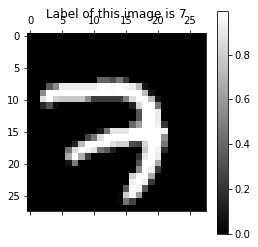

In [10]:
# Let's see 'input_r'
print ("Size of 'input_r' is %s" % (input_r.shape,))
label = np.argmax(trainlabel[0, :])
print ("Label is %d" % (label))

# Plot ! 
plt.matshow(input_r[0, :, :, 0], cmap=plt.get_cmap('gray'))
plt.title("Label of this image is " + str(label) + "")
plt.colorbar()
plt.show()

# Conv1 (convolution)

Size of 'conv1' is (1, 28, 28, 64)


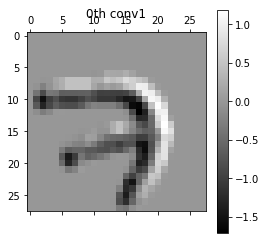

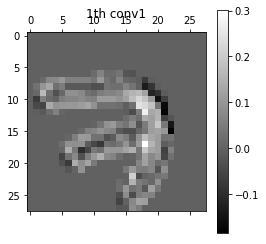

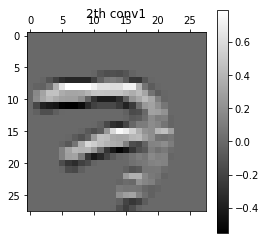

In [11]:
# Let's see 'conv1'
print ("Size of 'conv1' is %s" % (conv1.shape,))

# Plot ! 
for i in range(3):
    plt.matshow(conv1[0, :, :, i], cmap=plt.get_cmap('gray'))
    plt.title(str(i) + "th conv1")
    plt.colorbar()
    plt.show() 

# Conv2 (+bias)

Size of 'conv2' is (1, 28, 28, 64)


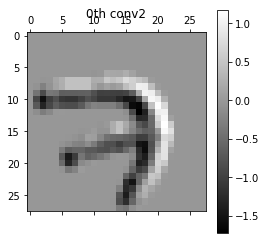

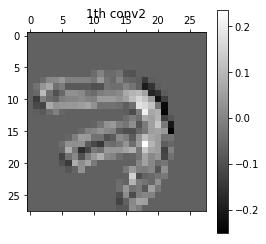

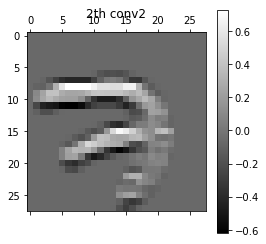

In [12]:
# Let's see 'conv2'
print ("Size of 'conv2' is %s" % (conv2.shape,))

# Plot ! 
for i in range(3):
    plt.matshow(conv2[0, :, :, i], cmap=plt.get_cmap('gray'))
    plt.title(str(i) + "th conv2")
    plt.colorbar()
    plt.show() 

# Conv3 (ReLU)

Size of 'conv3' is (1, 28, 28, 64)


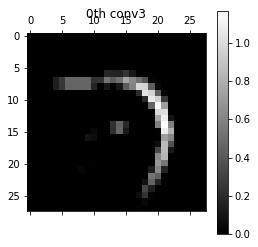

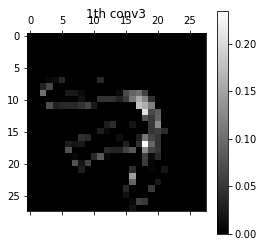

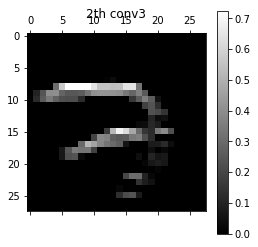

In [13]:
# Let's see 'conv3'
print ("Size of 'conv3' is %s" % (conv3.shape,))

# Plot ! 
for i in range(3):
    plt.matshow(conv3[0, :, :, i], cmap=plt.get_cmap('gray'))
    plt.title(str(i) + "th conv3")
    plt.colorbar()
    plt.show() 

# Pool (max_pool)

Size of 'pool' is (1, 14, 14, 64)


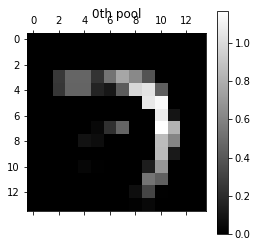

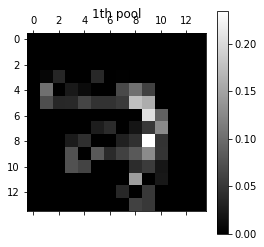

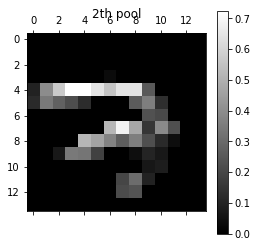

In [14]:
# Let's see 'pool'
print ("Size of 'pool' is %s" % (pool.shape,))

# Plot ! 
for i in range(3):
    plt.matshow(pool[0, :, :, i], cmap=plt.get_cmap('gray'))
    plt.title(str(i) + "th pool")
    plt.colorbar()
    plt.show() 

# Dense

In [15]:
# Let's see 'dense'
print ("Size of 'dense' is %s" % (dense.shape,))
# Let's see 'out'
print ("Size of 'out' is %s" % (out.shape,))

Size of 'dense' is (1, 12544)
Size of 'out' is (1, 10)


# Convolution filters

Size of 'wc1' is (3, 3, 1, 64)


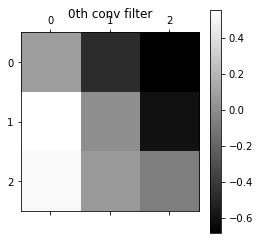

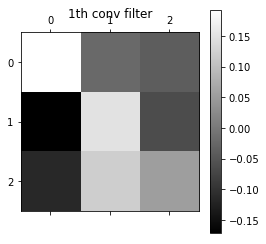

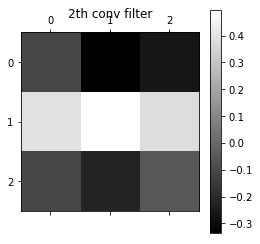

In [16]:
# Let's see weight! 
wc1 = sess.run(weights['wc1'])
print ("Size of 'wc1' is %s" % (wc1.shape,))

# Plot ! 
for i in range(3):
    plt.matshow(wc1[:, :, 0, i], cmap=plt.get_cmap('gray'))
    plt.title(str(i) + "th conv filter")
    plt.colorbar()
    plt.show() 